# Thin Sample Ptychography: A simple example

Tutorial created in collaboration between Diamond and SCD.

*Authors*
- Benedikt Daurer ([benedikt.daurer@diamond.ac.uk]())
- Darren Batey ([darren.batey@diamond.ac.uk]())

The notebook has been adapted to work with the previous notebook (1_forward_model_3d).

## Data collection

### Load test images as the object

In [1]:
image_path_phase = './results/object_field_cross_section_phase.tif'
image_path_modulus = './results/object_field_cross_section_modulus.tif'

### Reconstruction parameters

In [2]:
import json

# Load parameters from parameters.json
with open('./results/parameters.json', 'r') as f:
    params = json.load(f)

scan_points_xy = params['scan_points_xy']
scan_step_size = params['scan_step_size']
detector_shape = params['detector_shape']
probe_diameter = params['probe_diameter']
probe_type = params['probe_type']

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from astropy.convolution import AiryDisk2DKernel

def create_probe(shape, radius, signal=1, probe_type="disk"):
    if probe_type == "disk":
        ap = signal*np.ones(shape, dtype=np.complex64)
        radius= np.array(radius)
        cent = np.divide(shape,2)

        x = np.arange(0,np.size(ap,0)) - cent[0]
        y = np.arange(0,np.size(ap,1)) - cent[1]

        yy, xx = np.meshgrid(y, x)
        grid = np.sqrt((xx**2)+(yy**2))
        ap[grid>np.mean(radius)] = 0
        return ap
    elif probe_type == "airy_disk":
        # Use AiryDisk2DKernel from astropy to generate the Airy disk
        kernel = AiryDisk2DKernel(radius, x_size=shape[0], y_size=shape[1])

        airy_amp = np.array(kernel.array, dtype=np.float32)
        # Normalize amplitude to signal
        airy_amp *= signal / np.max(airy_amp)

        # Create a phase profile (e.g., quadratic phase for focusing)
        x = np.arange(shape[0]) - shape[0] // 2
        y = np.arange(shape[1]) - shape[1] // 2
        xx, yy = np.meshgrid(x, y)
        grid = np.sqrt(xx**2 + yy**2)
        phase = np.pi * ((xx**2 + yy**2) / (radius**2))
        phase = np.mod(phase, 0.5*np.pi)  # keep phase in [0, 0.5*pi]

        return airy_amp * np.exp(1j * phase)



def create_object(im_mod, im_phase, probe, positions, step):
    n_pos = positions.shape[-1]
    n_pos_x = np.ceil(np.sqrt(n_pos))
    n_pos_y = np.ceil(np.sqrt(n_pos))
    local_shape = probe.shape
    global_shape = np.array(local_shape)
    global_shape[0] += n_pos_y*step
    global_shape[1] += n_pos_x*step
    
    if im_mod is None:
        im_mod = np.ones(global_shape, dtype=np.float32)
    else:
        im_mod = im_mod.resize(global_shape)
        im_mod = np.array(im_mod, dtype=np.float32)
        im_mod -= np.min(im_mod)
        im_mod /= np.max(im_mod)
    if im_phase is None:
        im_phase = np.zeros(global_shape, dtype=np.float32)
    else:
        im_phase = im_phase.resize(global_shape)
        im_phase = np.array(im_phase, dtype=np.float32)
        im_phase -= np.min(im_phase)
        im_phase /= np.max(im_phase)
        im_phase *= np.pi
    
    obj = im_mod * np.exp(1j * im_phase)
    return obj

def create_positions(n, step):
    forward = True
    position_number = 0
    pos = np.zeros([2, n*n], dtype=np.int32)

    for j in range(n):
        for i in range(n):
            if forward:
                pos[1, position_number] = i * step
                pos[0, position_number] = j * step
            else:
                pos[1, position_number] = (n-i-1) * step
                pos[0, position_number] = j * step
            position_number += 1
        forward = not forward
    
    pos[0,:] = pos[0,:] - np.floor(np.mean(pos[0,:]))
    pos[1,:] = pos[1,:] - np.floor(np.mean(pos[1,:]))
    return pos


def cut(ar, pos, shape):
    centre = np.divide(shape, 2)
    centre = np.floor(centre)
    shape = np.int32(np.round(shape))
    pos[0] = pos[0] - np.floor(shape[0]/2)
    pos[1] = pos[1] - np.floor(shape[1]/2)
    ar_cut = np.copy(ar[pos[0]:(pos[0] + shape[0]), pos[1]:(pos[1] + shape[1])])
    return ar_cut


def create_data(obj, probe, positions):
    global_shape = np.int32(obj.shape)
    local_shape = np.int32(probe.shape)
    data = np.zeros([positions.shape[1], local_shape[0], local_shape[1]], dtype=np.float32)
    exit_wave = np.zeros([positions.shape[1], local_shape[0], local_shape[1]], dtype=np.complex64)
    local = np.zeros([positions.shape[1], local_shape[0], local_shape[1]], dtype=np.complex64)
    
    positions[0,:] = positions[0,:] + np.floor(global_shape[0]/2)
    positions[1,:] = positions[1,:] + np.floor(global_shape[1]/2)
    
    for frame_number in range(positions.shape[1]):
        local[frame_number, :, :] = cut(obj, positions[:,frame_number], local_shape)
        exit_wave[frame_number, :, :] = local[frame_number, :, :] * probe
        data[frame_number, :, :] = np.random.poisson(np.square(np.abs(np.fft.fftshift(np.fft.fft2(exit_wave[frame_number, :, :])))))

    return data, exit_wave, local

In [4]:
if image_path_modulus == '':
    im_modulus = None
else:
    im_modulus = Image.open(image_path_modulus)
if image_path_phase == '':
    im_phase = None
else:
    im_phase = Image.open(image_path_phase)

In [5]:
positions = create_positions(scan_points_xy, scan_step_size)
probe = create_probe(detector_shape, probe_diameter/2, signal=1, probe_type=probe_type)
obj = create_object(im_modulus,im_phase, probe, positions, scan_step_size)
_, exit_wave_approx, local = create_data(obj, probe, positions)
data = np.load('./results/data.npy')
exit_wave_paraxial = np.load('./results/exit_wave.npy')
probe_paraxial = np.load('./results/probe.npy')


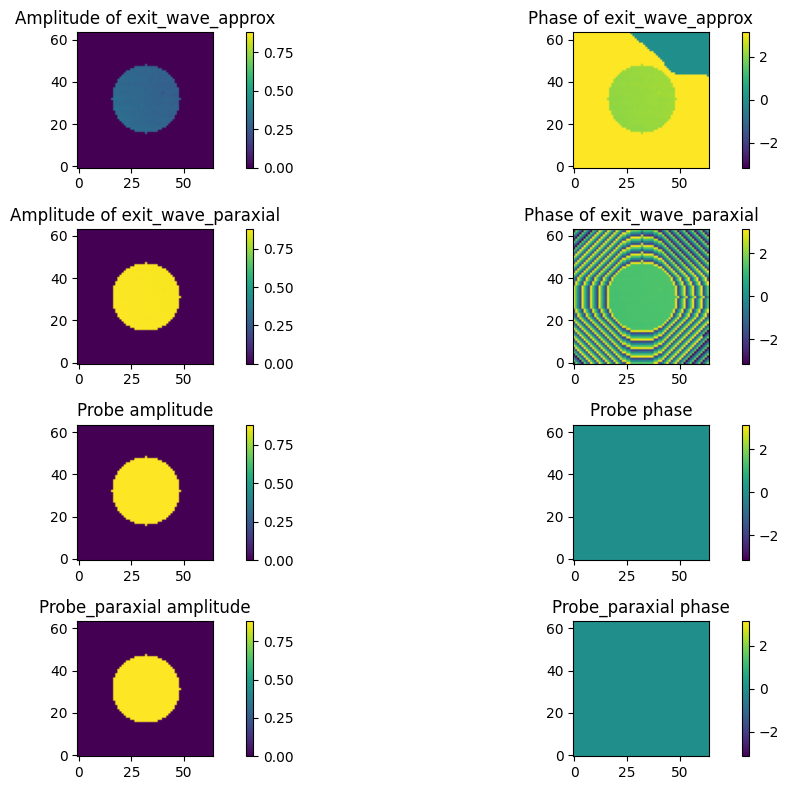

In [6]:
probe_idx = 0

fig, axs = plt.subplots(4, 2, figsize=(12, 8))

# Amplitude plots
amp_min = min(np.abs(exit_wave_approx[probe_idx,:,:]).min(), np.abs(exit_wave_paraxial[probe_idx,:,:]).min())
amp_max = max(np.abs(exit_wave_approx[probe_idx,:,:]).max(), np.abs(exit_wave_paraxial[probe_idx,:,:]).max())

im0 = axs[0, 0].imshow(np.abs(exit_wave_approx[probe_idx,:,:]), cmap='viridis', origin='lower', vmin=amp_min, vmax=amp_max)
axs[0, 0].set_title('Amplitude of exit_wave_approx')
plt.colorbar(im0, ax=axs[0, 0])

im2 = axs[1, 0].imshow(np.abs(exit_wave_paraxial[probe_idx,:,:]), cmap='viridis', origin='lower', vmin=amp_min, vmax=amp_max)
axs[1, 0].set_title('Amplitude of exit_wave_paraxial')
plt.colorbar(im2, ax=axs[1, 0])

# Phase plots
phase_min = min(np.angle(exit_wave_approx[probe_idx,:,:]).min(), np.angle(exit_wave_paraxial[probe_idx,:,:]).min())
phase_max = max(np.angle(exit_wave_approx[probe_idx,:,:]).max(), np.angle(exit_wave_paraxial[probe_idx,:,:]).max())

im1 = axs[0, 1].imshow(np.angle(exit_wave_approx[probe_idx,:,:]), cmap='viridis', origin='lower', vmin=phase_min, vmax=phase_max)
axs[0, 1].set_title('Phase of exit_wave_approx')
plt.colorbar(im1, ax=axs[0, 1])

im3 = axs[1, 1].imshow(np.angle(exit_wave_paraxial[probe_idx,:,:]), cmap='viridis', origin='lower', vmin=phase_min, vmax=phase_max)
axs[1, 1].set_title('Phase of exit_wave_paraxial')
plt.colorbar(im3, ax=axs[1, 1])

# Probe amplitude and phase
im4 = axs[2, 0].imshow(np.abs(probe), cmap='viridis', origin='lower', vmin=amp_min, vmax=amp_max)
axs[2, 0].set_title('Probe amplitude')
plt.colorbar(im4, ax=axs[2, 0])

im5 = axs[2, 1].imshow(np.angle(probe), cmap='viridis', origin='lower', vmin=phase_min, vmax=phase_max)
axs[2, 1].set_title('Probe phase')
plt.colorbar(im5, ax=axs[2, 1])

# Probe amplitude and phase
im4 = axs[3, 0].imshow(np.abs(probe_paraxial[probe_idx,:,:]), cmap='viridis', origin='lower', vmin=amp_min, vmax=amp_max)
axs[3, 0].set_title('Probe_paraxial amplitude')
plt.colorbar(im4, ax=axs[3, 0])

im5 = axs[3, 1].imshow(np.angle(probe_paraxial[probe_idx,:,:]), cmap='viridis', origin='lower', vmin=phase_min, vmax=phase_max)
axs[3, 1].set_title('Probe_paraxial phase')
plt.colorbar(im5, ax=axs[3, 1])

plt.tight_layout()
plt.show()

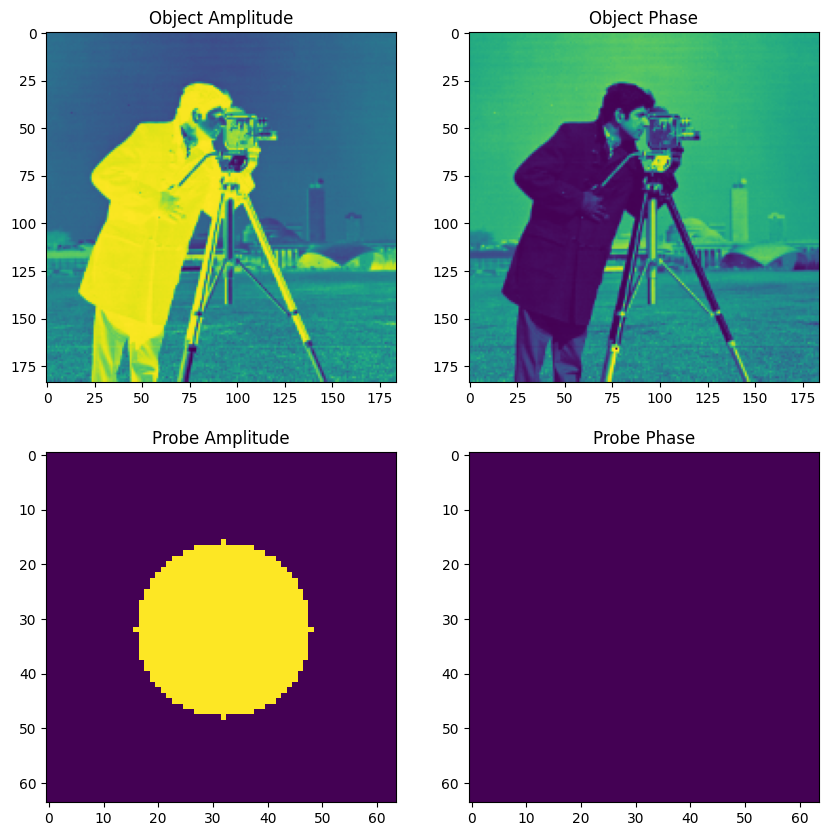

In [7]:

plt.figure('pty data simulation', figsize=[10,10])
plt.subplot(2,2,1)
plt.title('Object Amplitude')
im_obj_amp = plt.imshow(np.abs(obj), cmap='viridis')
plt.subplot(2,2,2)
plt.title('Object Phase')
im_obj_phase = plt.imshow(np.angle(obj), cmap='viridis')
plt.subplot(2,2,3)
plt.title('Probe Amplitude')
im_probe_amp = plt.imshow(np.abs(probe), cmap='viridis')
plt.subplot(2,2,4)
plt.title('Probe Phase')
im_probe_phase = plt.imshow(np.angle(probe), cmap='viridis')
# plt.subplot(2,2,3)
# plt.title('Scan positions')
# plt.plot(positions[1,:], positions[0,:], '-or')
# plt.axis('square')
# plt.subplot(2,3,6)
# plt.title('Single data frame [log]')
# plt.imshow(np.log(data[1,:,:]))
# plt.show()

## Simple reconstruction from "data and model" notebook

### Reconstruction parameters

In [8]:
num_iterations = 60

In [9]:
from utils import scan_pos_pix, scan_view_limits

In [10]:
# Convert scan positions to pixel units
posx_pix = positions[1,:]
posy_pix = positions[0,:]
# Calculate lower and higher limits for each scan view
xlow, xhigh, ylow, yhigh, xcentre, ycentre = scan_view_limits(posx_pix, posy_pix, probe.shape)
# Create initial object array
obj_shape = (yhigh.max()+1, xhigh.max()+1)
obj = np.ones(obj_shape, dtype=complex)
# Create probe array
initial_probe = np.copy(probe) # in the more general case this can just be an empty array of noise

In [11]:
# Calculate mean power in diffraction data
mean_power = np.mean(np.abs(data))

In [12]:
# Create empty object array
obj = np.ones(obj_shape, dtype=complex)
# Create initial probe array
probe = np.copy(initial_probe) # in the more general case this can just be an empty array of noise

In [13]:
num_positions = len(posx_pix)
alpha = 1e-5
beta = 0.1
lerror = np.zeros(num_positions)
gerror = np.zeros(num_iterations)
fft_scaling = 1./np.sqrt(np.prod(probe.shape))
positions = np.arange(num_positions)
j = 0

In [14]:
# The main iteration loop
for j in range(num_iterations):
    print("Iteration %d" %j)
    # Randomize the order of the scan positions
    np.random.shuffle(positions)
    
    # Going through all the scan positions
    for i in positions:

            #print("Position %d" %i)
        
            # The object view
            ov  = obj[ylow[i]:yhigh[i],xlow[i]:xhigh[i]]

            # The exit wave view
            ev = probe*ov

            # The model in Fourier space
            fmodel = np.fft.ifftshift(np.fft.fftn((ev))) * fft_scaling

            # Keep track of the error
            lerror[i] = np.sum((np.abs(fmodel)**2 - data[i])**2) / np.prod(fmodel.shape)

            # Apply the data constraint
            fmodel = np.sqrt(data[i]) * np.exp(1j * np.angle(fmodel))

            # New exit wave
            emodel = np.fft.ifftn(np.fft.fftshift(fmodel)) / fft_scaling

            # Power correction for probe
            probe *= np.sqrt(mean_power / (np.abs(probe)**2).mean())

            # Update the object
            ov += beta * np.conj(probe) / np.max(np.abs(probe)**2) * (emodel - ev)

            # Update the probe
            probe += beta * np.conj(ov) / np.max(np.abs(obj)**2) * (emodel - ev)

    # Save average error
    gerror[j] = np.mean(lerror)

    j += 1

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59


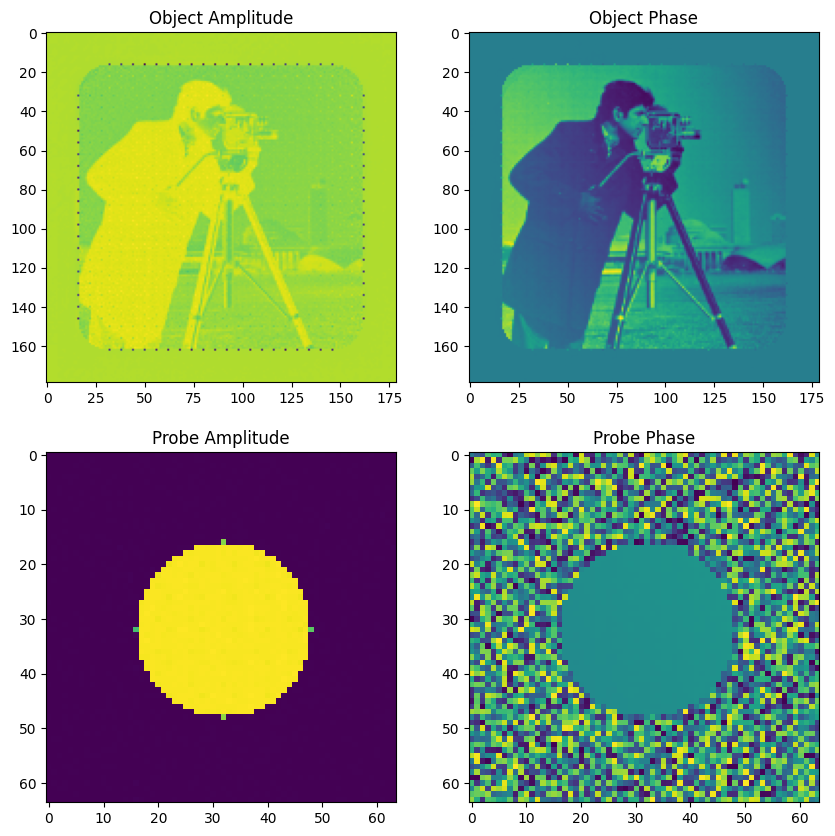

In [19]:
plt.figure('pty data reconstruction', figsize=[10,10])
plt.subplot(2,2,1)
plt.title('Object Amplitude')
im_obj_amp = plt.imshow(np.abs(obj/np.max(probe)))#, cmap='viridis', vmin=0, vmax=1.2)
# plt.colorbar(im_obj_amp)
plt.subplot(2,2,2)
plt.title('Object Phase')
im_obj_phase = plt.imshow(np.angle(obj), cmap='viridis')#, vmin=phase_min, vmax=phase_max)
#plt.colorbar(im_obj_phase)
plt.subplot(2,2,3)
plt.title('Probe Amplitude')
im_probe_amp = plt.imshow(np.abs(probe), cmap='viridis')#, vmin=0, vmax=1.2)
# plt.colorbar(im_probe_amp)
plt.subplot(2,2,4)
plt.title('Probe Phase')
im_probe_phase = plt.imshow(np.angle(probe), cmap='viridis')#, vmin=phase_min, vmax=phase_max)
# plt.colorbar(im_probe_phase)

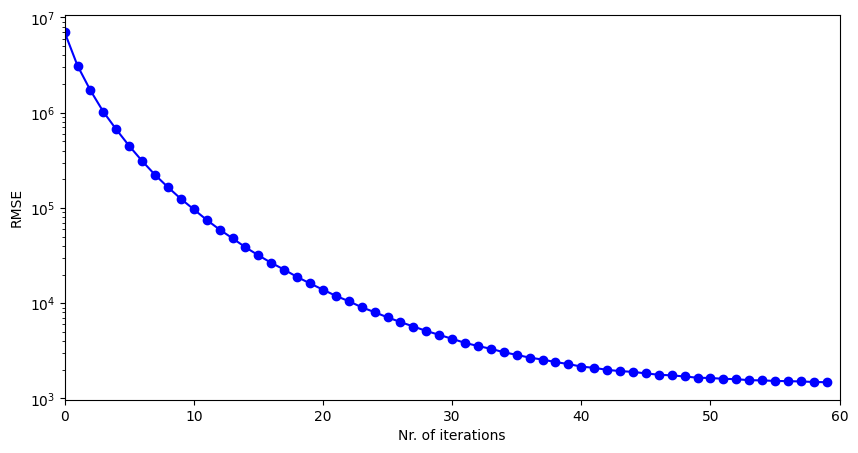

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(num_iterations), gerror, "bo-")
plt.xlim(0,num_iterations)
plt.semilogy()
plt.xlabel("Nr. of iterations")
plt.ylabel("RMSE")
plt.show()